1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe


In [67]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random
import seaborn as sns

In [68]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert default and student to categorical variables.

In [69]:
df['default'] = df['default'].replace({'No': 'No default', 'Yes': 'default'})
df['student'] = df['student'].replace({'No': 'Not student', 'Yes': 'student'})

df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])

df_final = pd.concat([df_default, df_student, df[['balance','income']]], axis=1)

# Keep only the "Default" and "Student" columns
df_final = df_final[['default','student', 'balance', 'income']]
df_final.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no.

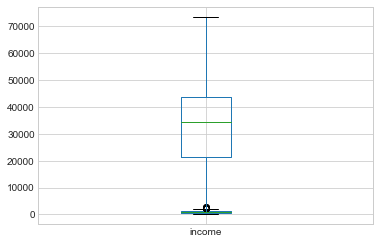

In [91]:
df_final[['balance']].boxplot()

In [ ]:
df_final[['income']].boxplot()

Text(0.5,1,'Boxplot for the variables balance, default and student')

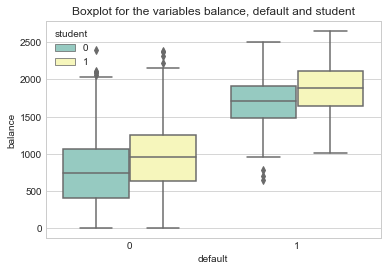

In [70]:
sns.set_style("whitegrid")
sns.boxplot(x = "default", y = "balance", hue = "student", 
            data= df_final, palette="Set3").set_title('Boxplot for the variables balance, default and student')

Text(0.5,1,'Boxplot for the variables income, default and student')

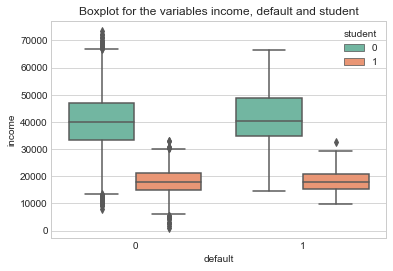

In [71]:
sns.boxplot(x = "default", y = "income", hue="student", data= df_final, 
            palette="Set2").set_title('Boxplot for the variables income, default and student')

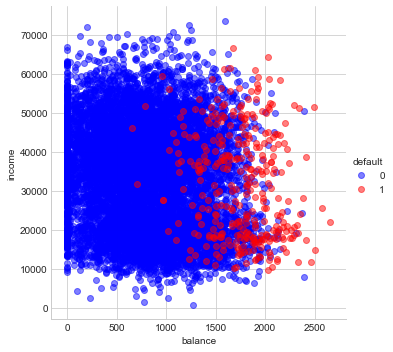

In [72]:
colors = ["blue", "red"]

sns.lmplot(x = "balance", y = "income", data = df_final, 
           fit_reg = False, hue = 'default', 
           palette = colors, scatter_kws={'alpha':0.5})


4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [98]:
y = df_final['default']
X = df_final[['balance','income']]

from sklearn.model_selection import train_test_split

#Creating the training and testing set
random_state = np.random.RandomState(0)
X, y = shuffle(X, y, random_state = random_state)
n_samples, n_features = X.shape
half = int(n_samples/1.2)
X_train, X_test = X[:half], X[half:]
y_train, y_test = y[:half], y[half:]

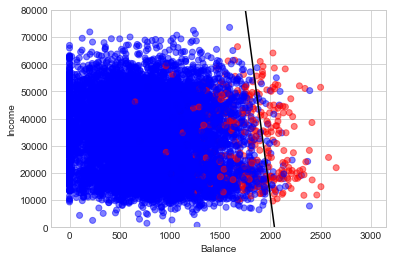

In [105]:
logreg = LogisticRegression(penalty = 'l1')
logreg.fit(X_train,y_train)

color = np.where(df_default['default']==1,'r', 'b')

w = logreg.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0, 3000, 50)
yy = a * xx - (logreg.intercept_[0]) / w[1]
plt.plot(xx, yy, 'k-')
plt.scatter(df['balance'],df['income'], alpha=0.5, c = color)
plt.ylim([0, 80000])
plt.ylabel('Income')
plt.xlabel('Balance')
plt.show()

Area under the ROC curve : 0.942398


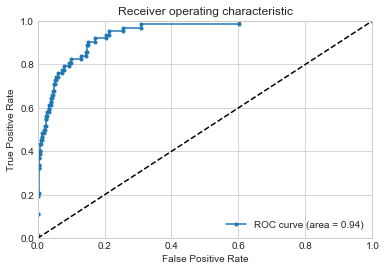

In [106]:
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?

In [175]:
y = df_final['default']
X2 = df_final[['balance','income', 'student']]

from sklearn.model_selection import train_test_split

#Creating the training and testing set
random_state = np.random.RandomState(0)
X2, y = shuffle(X2, y, random_state = random_state)
n_samples, n_features = X.shape
half = int(n_samples/1.2)
X2_train, X2_test = X2[:half], X_2[half:]
y_train, y_test = y[:half], y[half:]

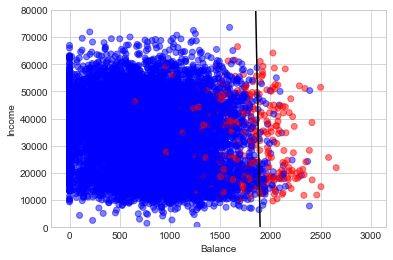

In [166]:
# Plotting the new decision boundary using logistic regression
logreg = LogisticRegression(penalty = 'l1')
logreg.fit(X2_train,y_train)

color = np.where(df_default['default']==1,'r', 'b')

w = logreg.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0, 3000, 50)
yy = a * xx - (logreg.intercept_[0]) / w[1]
plt.plot(xx, yy, 'k-')
plt.scatter(df['balance'],df['income'], alpha=0.5, c = color)
plt.ylim([0, 80000])
plt.ylabel('Income')
plt.xlabel('Balance')
plt.show()

Area under the ROC curve : 0.962295


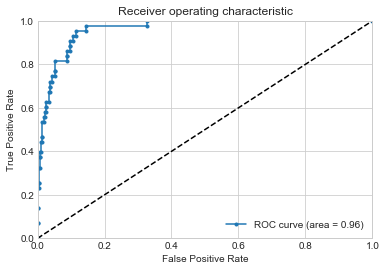

In [108]:
def generate_auc(X2,y2,clf_class,**kwargs):
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X2_train, y_train).predict_proba(X2_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X2,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

Comparing performance for the logistic regressions with and without the added variable based on ROC curve, we can see that the area under the ROC curve increased from 0.942398 to 0.942398 after adding the student variable which means that there is an improvement in performance.



In [176]:
# Using ridge regression,

from sklearn.linear_model import Ridge

alphas = np.logspace(-8,-3,1000)
train_errors = []
test_errors = []
scores = []
for alpha in alphas:
    ridgeregr = Ridge(alpha = alpha)
    # Then, I train the model using training sets
    ridgeregr.fit(X2_train, y_train)
    train_errors.append(ridgeregr.score(X2_train, y_train))
    scores.append(ridgeregr.score(X2_test, y_test))

# To find the optimum alpha,
alpha_optim = alphas[np.argmax(scores)]

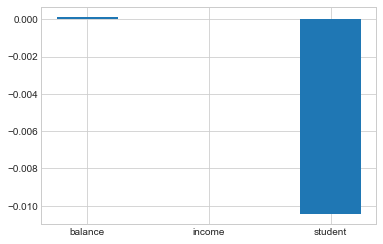

The coefficients are: [  1.37717853e-04   2.17801330e-07  -1.04677188e-02]


In [186]:
ridgereg = Ridge(alpha= alpha_optim)
ridgereg.fit(X2_train,y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), ridgereg.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))

plt.show()
print ('The coefficients are:', ridgereg.coef_)


6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

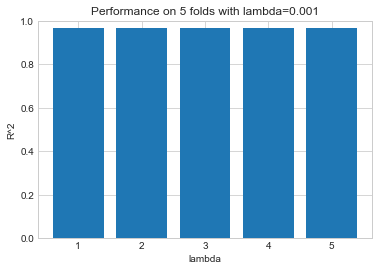

[ 0.96651674  0.96651674  0.9665      0.96698349  0.96698349]


In [193]:
from sklearn.model_selection import cross_val_score

regr = LogisticRegression(C = alpha_optim, penalty = 'l2')
scores = cross_val_score(regr, X_scaled, y, cv=5)
plt.ylim([0,1])
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 5 folds with lambda=' + str(alpha))
plt.bar(range(1,6),scores)
plt.show()

print(scores)

From the graph above, since the R^2 values are all at least 0.966 for the different subsets, this model does fit the data pretty well and would be able to work well on all the random subsets.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [194]:
print(__doc__)

# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Fit regression model
regr_0 = DecisionTreeRegressor(max_depth=1)
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_0.fit(X2_train, y_train)
regr_1.fit(X2_train, y_train)
regr_2.fit(X2_train, y_train)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_0 = regr_0.predict(X2_test)
y_1 = regr_1.predict(X2_test)
y_2 = regr_2.predict(X2_test)


def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

Automatically created module for IPython interactive environment


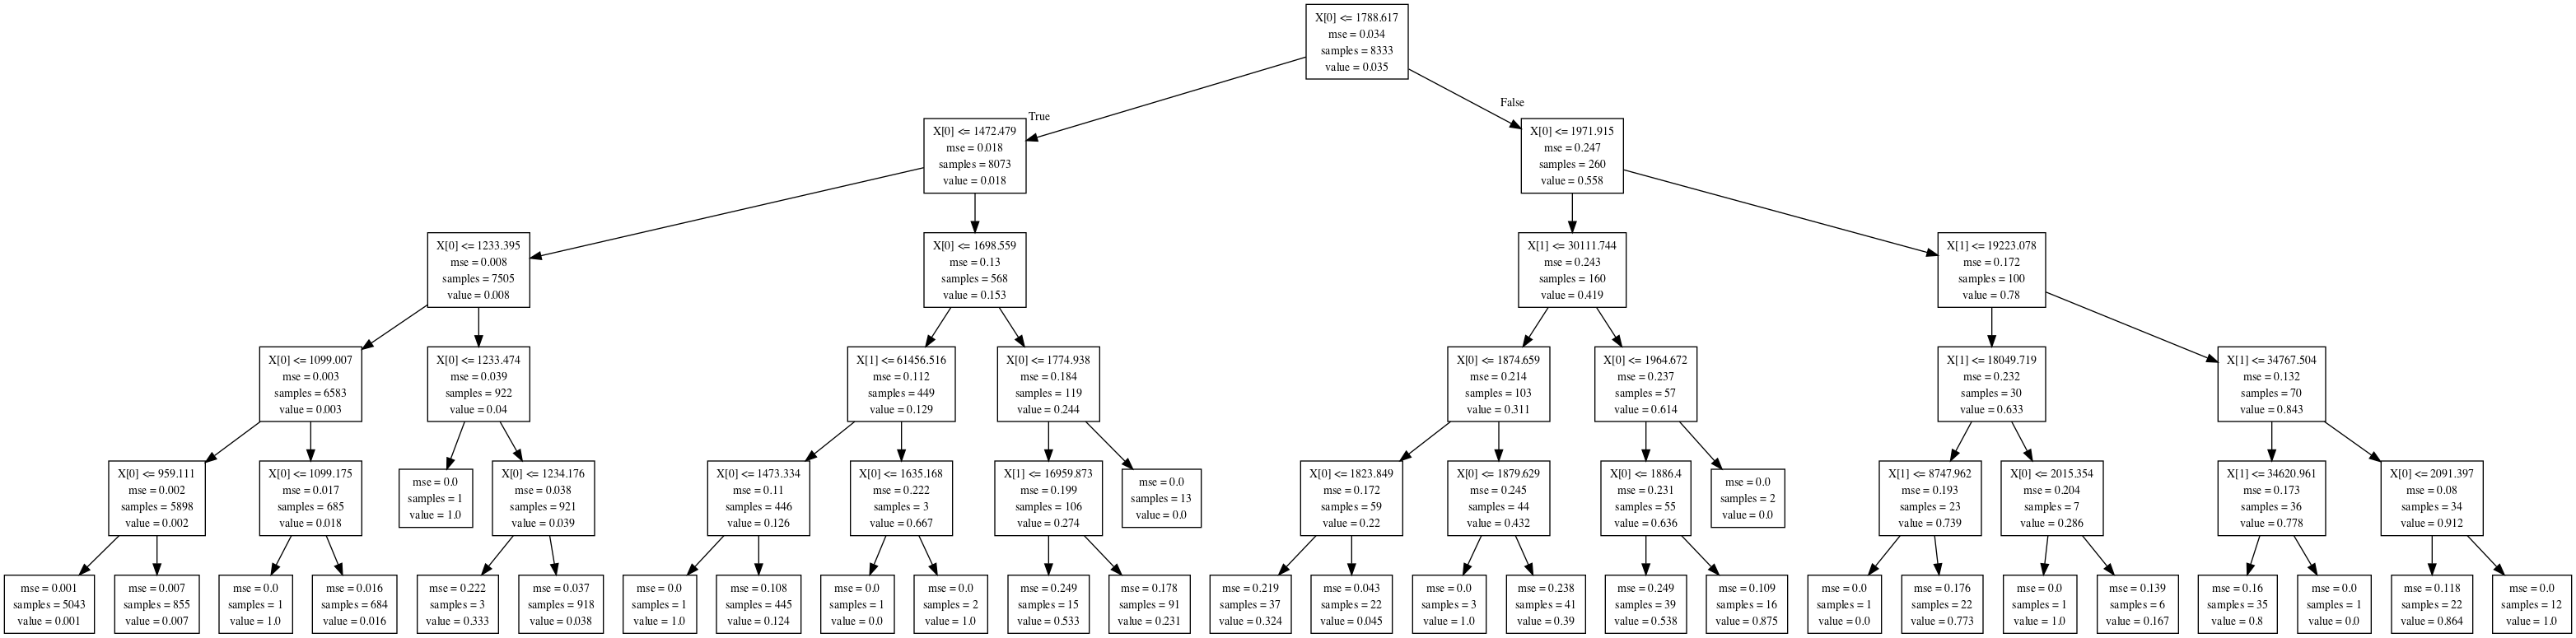

In [196]:
from IPython.display import Image 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus

dot_data = export_graphviz(regr_2, out_file = None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC.

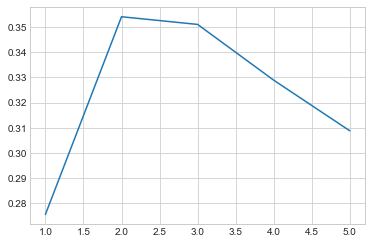

In [197]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, 
                                                      random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X2_train, y_train)
    train_errors.append(regr.score(X2_train,y_train))
    scores.append(regr.score(X2_test,y_test))
    
plt.plot(depths, scores)
test_errors = scores
n_opt = depths[np.argmax(scores)]

# The optimal tree depth is 2

Area under the ROC curve : 0.892216


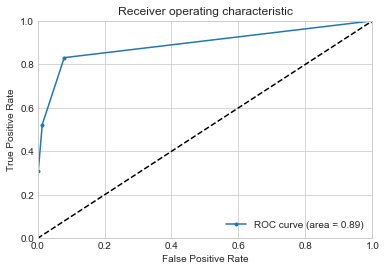

In [200]:
tree_opt = DecisionTreeRegressor(max_depth = n_opt)
tree_opt.fit(X2_train, y_train)

y_pred = tree_opt.predict(X2_test)

def generate_auc(X2,y,clf_class,**kwargs):
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

fpr,tpr,roc_auc, thresholds = generate_auc(X2_train,y_train,
                                           DecisionTreeRegressor,max_depth = n_opt)
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'Decision Tree',roc_auc)